# Deep Learning QA Bot

## Loading the data

We will be working with the Babi Data Set from Facebook Research.

Full Details: https://research.fb.com/downloads/babi/

- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698
  

## Goal of this Project

+ To implement as chat bot that can answer questions basded on a "story" given to the bot

# There will be three components to this project

### Example

+ Story: Jane went to the store. Mike ran to the bedroom.

+ Question: Is Mike in the store?

+ Goal - Bot to answer: No



# How the QA Bot Network Works

+ Model takes a discrete set of inputs that are to be stored in the memory
+ It will take a corresponding question and output an answer
+ Each of the inputs, questions and answers contain symbols coming from a dictionary with vocabulary words
+ Model then write all of the text to the memory up to a fixed buffer size, and then finds a continuous representation for the text and question

In [1]:
# importing libraries

import pickle
import numpy as np

In [6]:
# unpickling train text data and storing it into a variable

with open("train_qa.txt", "rb") as fp:    # Unpickling
    train_data = pickle.load(fp)

In [7]:
# unpickling test text data and storing it into a variable

with open("test_qa.txt", "rb") as fp:    # Unpickling
    test_data = pickle.load(fp)

## Exploring the Format of the Data

In [9]:
# using the type function to understand the type of object the test data is

type(test_data)

list

In [10]:
# using the type function to understand the type of object the training data is

type(train_data)

list

In [11]:
# now looking at the length of the test data

len(test_data)

1000

In [12]:
# now looking at the length of the train data

len(train_data)

10000

In [13]:
# taking a look at the first tuple in the training data

train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [17]:
# concatenating the first tuple into a sentence

' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [18]:
# concatenating the question in the first tuple

' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [19]:
# printing out the answer in the first tuple

train_data[0][2]

'no'

In [20]:
# create a set that holds the vocab words
# stores unique values

vocab = set()

In [21]:
# creating a new variable that contrains both datasets and is a big list

all_data = test_data + train_data

In [22]:
# creating a for loop to add all distinct words for the story, the question and the answer

for story, question , answer in all_data:
    vocab = vocab.union(set(story)) # union will look for all distinct values between the two sets / continuously adding new distinct words while keeping current list in consideration
    vocab = vocab.union(set(question)) # 

In [23]:
# adding yes and no to the vocabulary

vocab.add('no')
vocab.add('yes')

In [24]:
# looking at the set of all possible vocab words

vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [25]:
 #we add an extra space to hold a 0 for Keras's pad_sequences

vocab_len = len(vocab) + 1

In [26]:
max_story_len = max([len(data[0]) for data in all_data])

In [27]:
max_story_len

156

In [28]:
max_question_len = max([len(data[1]) for data in all_data])

In [29]:
max_question_len

6

In [30]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [31]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [32]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [33]:
# integer encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [34]:
tokenizer.word_index

{'kitchen': 1,
 'to': 2,
 'went': 3,
 'daniel': 4,
 'dropped': 5,
 'got': 6,
 'is': 7,
 'left': 8,
 'sandra': 9,
 '?': 10,
 'journeyed': 11,
 'there': 12,
 '.': 13,
 'bedroom': 14,
 'office': 15,
 'milk': 16,
 'took': 17,
 'john': 18,
 'picked': 19,
 'hallway': 20,
 'moved': 21,
 'apple': 22,
 'mary': 23,
 'grabbed': 24,
 'the': 25,
 'in': 26,
 'garden': 27,
 'put': 28,
 'back': 29,
 'football': 30,
 'down': 31,
 'travelled': 32,
 'yes': 33,
 'bathroom': 34,
 'up': 35,
 'no': 36,
 'discarded': 37}

In [35]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [36]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [37]:
len(train_story_text)

10000

In [38]:
len(train_story_seq)

10000

In [39]:
# word_index = tokenizer.word_index

In [40]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [41]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [42]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [43]:
inputs_test

array([[ 0,  0,  0, ..., 25, 14, 13],
       [ 0,  0,  0, ..., 25, 27, 13],
       [ 0,  0,  0, ..., 25, 27, 13],
       ...,
       [ 0,  0,  0, ..., 25, 22, 13],
       [ 0,  0,  0, ..., 25, 27, 13],
       [ 0,  0,  0, ..., 22, 12, 13]])

In [44]:
queries_test

array([[ 7, 18, 26, 25,  1, 10],
       [ 7, 18, 26, 25,  1, 10],
       [ 7, 18, 26, 25, 27, 10],
       ...,
       [ 7, 23, 26, 25, 14, 10],
       [ 7,  9, 26, 25, 27, 10],
       [ 7, 23, 26, 25, 27, 10]])

In [45]:
answers_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       497.,   0.,   0., 503.,   0.])

In [47]:
tokenizer.word_index['yes']

33

In [48]:
tokenizer.word_index['no']

36

## Creating the Model

In [50]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

### Placeholders for Inputs

Recall we technically have two inputs, stories and questions. So we need to use placeholders. `Input()` is used to instantiate a Keras tensor.

In [51]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

### Building the Networks

To understand why we chose this setup, make sure to read the paper we are using:

* Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895

## Encoders

### Input Encoder m

In [53]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

### Input Encoder c

In [54]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

## Question Encoder

In [55]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

## Encode the Sequences

In [56]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

##### Use dot product to compute the match between first input vector seq and the query

In [57]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

#### Add this match matrix with the second input vector sequence

In [58]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

#### Concatenate

In [59]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [60]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [61]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [62]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [63]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [65]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=100,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 6s 7ms/step - loss: 0.8695 - accuracy: 0.4942 - val_loss: 0.6941 - val_accuracy: 0.5030
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 0.7032 - accuracy: 0.5013 - val_loss: 0.6960 - val_accuracy: 0.5030
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6957 - accuracy: 0.5028 - val_loss: 0.6939 - val_accuracy: 0.5030
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6943 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 5/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6946 - accuracy: 0.5060 - val_loss: 0.6982 - val_accuracy: 0.5030
Epoch 6/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6949 - accuracy: 0.4967 - val_loss: 0.6945 - val_accuracy: 0.4970
Epoch 7/100
313/313 [==============================] - 2s 6ms/step - loss: 0.6944 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.4970

In [66]:
### Saving the model

file = 'chatbot.h5'
model.save(file)

C:\Users\chaco\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Evaluating the Model

#### Plotting out Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


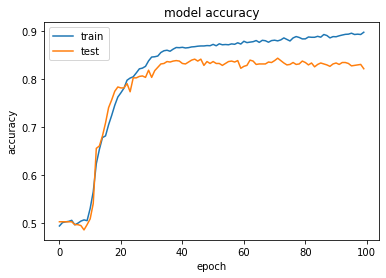

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluating on Given Test Set

In [69]:
model.load_weights(file)
pred_results = model.predict(([inputs_test, queries_test]))

In [70]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [71]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [72]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [73]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [74]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.99999917


## Writing Own Stories and Questions

Remember you can only use words from the existing vocab

In [75]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [76]:
my_question = "Is the football in the garden ?"

In [77]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [78]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [79]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [80]:
pred_results = model.predict(([ my_story, my_ques]))

In [81]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.99525106
